# Motor Control testing
This code tests the control of the PRUSA research NEMA17 1.8 degree x axis Stepper Motors using an Arduino UNO Board and an EasyDriver. Below is the schematic of how to set up the electronics for the circuit. 

Use this notebook to setup and test your motor and arduino connection. Use motor.py functions to more easily automate motor control.

Steps to run this test:
1. Build the board as shown below. (note: the voltage supply must be greater tha 6V and be constant)
2. Connect the Arduino to this computer.
3. On this computer, open the Arduino IDE and upload the StandardFirmata sketch. (Arduino_testing.ipynb for more information)
4. Run the following code.

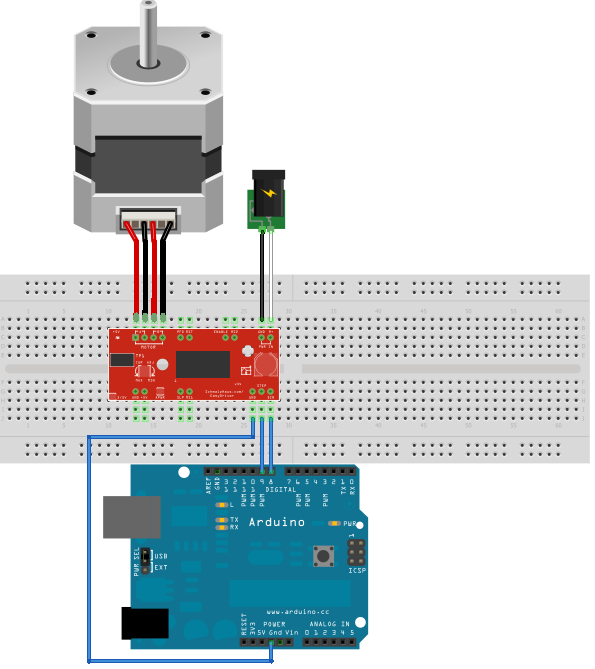

### Notes and measurements

- Length of the rod = 29 cm
- Length of the mounting piece = 5.1 cm
- 1 microstep = 1 write high
- 1600 microsteps per revolution
- threads per inch = 13 (one thread is possible one revolution)

- 1600 steps = 1 revolution = 1/13 inches = 0.195384615 cms
- 1 step = 0.00012211538437500001 cm = 0.122 micrometer

- 5 cm ~ 40944 microsteps

In [46]:
import pyfirmata
import time

In [47]:
def step(board, step_pin=9, dir_pin=8, en_pin= 3, direction=0):
    """
    Moves the Arduino one microstep.
    
    Inputs:
        step_pin (int): pin on arduino to control stepping
        dir_pin (int): pin on arduino to control direction
        direction (0 or 1): direction motor will move when stepped
    """
    
    board.digital[dir_pin].write(direction) # direction pin
    board.digital[step_pin].write(1)
    #time.sleep(.01) # lowest windows can get is 10ms, motor runs faster if we remove the time delay 
    board.digital[step_pin].write(0)
    #time.sleep(.01)
    return

In [48]:
# Use Arduino IDE to find the port name
# under Tools->Port
# This time is was COM3
board = pyfirmata.Arduino( 'COM3') 

In [50]:
# Setup the pins on the arduino
board.digital[8].write(1) # stepping pin 
board.digital[9].write(1) # direction pin

In [54]:
# Run the motor. Use this to test different directions and lengths of movement
reps = 500 # ammount to move the motor 
for i in range(reps+1):
    step(board_sipm,8,9, direction=-1) #(1 = up, -1=down)

# Testing button to stop motor from reaching the edge

Based on arduino pyfirmata tutorial (https://realpython.com/arduino-python/)

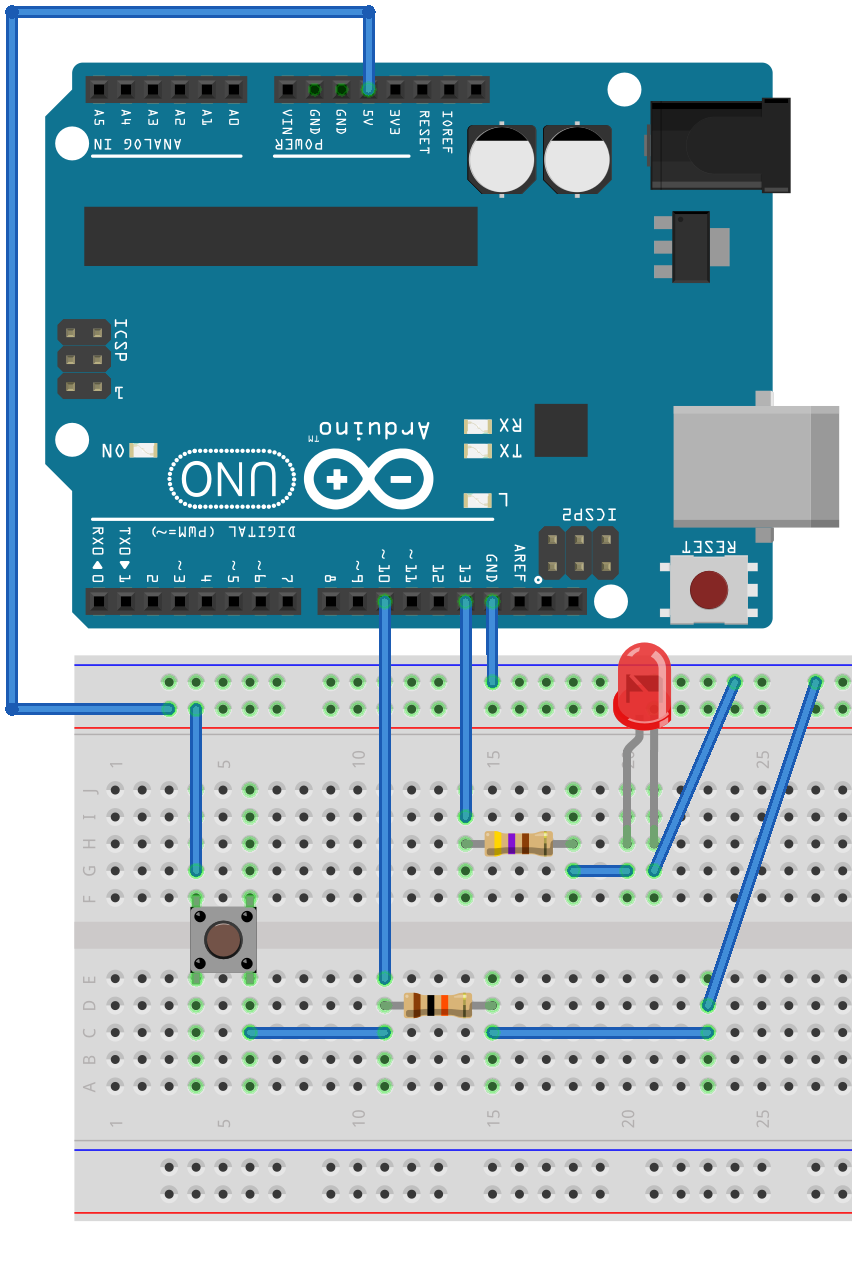

In [78]:
BOARD_BUTTON.digital[5].mode = pyfirmata.INPUT

In [40]:
import pyfirmata
import time
BOARD_BUTTON = pyfirmata.Arduino('COM3')

it = pyfirmata.util.Iterator(BOARD_BUTTON)
it.start()

BOARD_BUTTON.digital[6].mode = pyfirmata.INPUT
time.sleep(.01)

In [11]:
while True:
    at_edge = BOARD_BUTTON.digital[10].read()
    if at_edge is True:
        BOARD_BUTTON.digital[13].write(1)
    else:
        BOARD_BUTTON.digital[13].write(0)
    time.sleep(0.01) # avoid overloading the CPU, which reaches 100% load when there isn’t a wait command in the loop

KeyboardInterrupt: 

In [75]:
import csv

MAX_Z = 231. # Mazimum allowable height in mm
GRATING_LED_POSITION = 70. # LED position for alignment with grating
BELOW_GRATING_LED_POSITION = 67 # LED position for alignment below grating
BELOW_MOUNT_LED_POSITION = 45 # LED position for alignment below grating
SIPM_OFFSET = 13.86 #14.355 # Difference in height between SiPM and LeD for direct alignment. LED is lower.
NUM_SWEEPS = 15

class Motor:
    """
    Written by: Taylor Contreras (taylorcontreras@g.harvard.edu)

    This class controls defines the functions avaible
    to control a single motor in the
    metalens black box experiment. 
    """

    
    def __init__(self, board, step_pin, dir_pin, button_pin, name):
        self.board = board
        self.step_pin = step_pin
        self.dir_pin = dir_pin
        self.button_pin = button_pin
        self.name = name
    
    def step(self, direction=0):
        """
        Moves the stepper motor one microstep.

        Inputs:
            direction (0 or 1): direction motor will move when stepped
        """
        self.board.digital[self.dir_pin].write(direction) # direction pin
        self.board.digital[self.step_pin].write(1)
        #time.sleep(.01) # lowest windows can get is 10ms, motor runs faster if we remove the time delay 
        self.board.digital[self.step_pin].write(0)
        #time.sleep(.01)
        return

    def MoveMotor(self, distance, ignore_limits=False):
        """
        Moves either motor certain distance up or down.

        Inputs:
            distance (float): the distance to move the device, in mm
            ignore_limits (True/False):
        """

        # Calculate number of steps needed
        dx_per_step = .005 # mm
        num_steps = int(distance // dx_per_step)
        self.MoveSteps(num_steps, ignore_limits)

        return

    def SetToZero(self):
        """
        Set motor to zero steps.

        Inputs:
            steps (int): steps value to move to
        """
        self.SetSteps(0)

    def SetToTop(self):
        """
        Set motor to zero steps.

        Inputs:
            steps (int): steps value to move to
        """
        self.MoveMotor(MAX_Z-position-5)

    def SetSteps(self, steps):
        """
        Sets the motor a certain number of steps.

        Inputs:
            steps (int): steps value to move to
        """
        current_steps = self.GetCurrentNumSteps()
        steps_to_move = steps - current_steps
        self.MoveSteps(steps_to_move)

    def MoveSteps(self, num_steps, ignore_button=False):
        """
        Moves the motor a certain number of steps.

        Inputs:
            num_steps (int): number of steps to move the device (positive = up, negative = down)
            ignor_limits (True/False): 
        """
        num_steps = int(num_steps)
        if num_steps == 0: return

        dx_per_step = .005 # mm

        if num_steps < 0:
            motor_direction = 0
        else:
            motor_direction = 1

        # Step the motor
        for i in range(abs(num_steps)):
            push_button = BOARD_BUTTON.digital[self.button_pin].read()
            if push_button and not ignore_button:
                self.AlertAtEdge(num_steps//abs(num_steps))
                break
            self.step(motor_direction)

        current_num_steps = self.GetCurrentNumSteps()
        self.WriteNewNumSteps(current_num_steps+num_steps)

        return

    def GetCurrentNumSteps(self):
        """
        Reads the text file that stores the current number of step the sipm and motor
        have moved and returns the position based on the motor input in mm
        """
        rows = []
        with open('position_'+self.name+'.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                rows.append(row)

        return int(rows[0][0])

    def GetCurrentPosition(self):
        """
        Reads the text file that stores the current position of the motor
        and returns the position based on the motor input in mm
        """
        dx_per_step = .005 # mm
        rows = []
        with open('position_'+self.name+'.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                rows.append(row)
        
        return int(rows[0][0])*dx_per_step

    def WriteNewNumSteps(self, position):
        """
        Writes to the text file the new number of steps of the device from the bottom 
        """
        
        with open('position_'+str(self.name)+'.csv', 'w', newline='') as file:
            file.truncate()
            writer = csv.writer(file)
            
            writer.writerow([position])

        return

    def CreatePositionFile(self):
        """
        Creates the file to hold the position of the motor, set the motor
        at zero. 
        """
        with open('position_'+self.name+'.csv', mode='w') as file:
            writer = csv.writer(file)
            writer.writerow([0])
            
    def AlertAtEdge(self, original_dir):
        """
        Alerts the user that the motor has reached the edge of its movement
        and moves it 10 steps in the oposite direction.
        
        Inputs:
            original_dir (-1 or 1): The original direction of movement
        """
        current_pos = self.GetCurrentPosition()
        print('--------------------WARNING!---------------------')
        print(str(self.name)+' motor has reached edge (at '+str(current_pos)+' mm)')
        self.MoveSteps(-1*original_dir*1000, ignore_button=True)
        print('Moved away from edge, new positions is '+str(self.GetCurrentPosition())+' mm')
        print('-------------------------------------------------')
        return



In [79]:
sipm_step_pin = 8
sipm_dir_pin = 9
sipm_button_pin = 5
led_step_pin = 10
led_dir_pin = 11
led_button_pin = 6
sipm_motor = Motor(BOARD_BUTTON, sipm_step_pin, sipm_dir_pin, sipm_button_pin, 'sipm')
led_motor = Motor(BOARD_BUTTON, led_step_pin, led_dir_pin, led_button_pin, 'led')

In [84]:
for i in range(1,100):
    led_motor.MoveMotor(1)
    sipm_motor.MoveMotor(1)

--------------------WARNING!---------------------
sipm motor has reached edge (at 1085.865 mm)
Moved away from edge, new positions is 1080.865 mm
-------------------------------------------------
--------------------WARNING!---------------------
sipm motor has reached edge (at 1086.835 mm)
Moved away from edge, new positions is 1081.835 mm
-------------------------------------------------
--------------------WARNING!---------------------
sipm motor has reached edge (at 1087.805 mm)
Moved away from edge, new positions is 1082.805 mm
-------------------------------------------------
--------------------WARNING!---------------------
sipm motor has reached edge (at 1088.775 mm)
Moved away from edge, new positions is 1083.775 mm
-------------------------------------------------
--------------------WARNING!---------------------
sipm motor has reached edge (at 1088.75 mm)
Moved away from edge, new positions is 1083.75 mm
-------------------------------------------------
--------------------WA

KeyboardInterrupt: 